In [91]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import torch
from PIL import Image
from scipy.interpolate import interp1d

In [92]:
segment_path0 = Path("../../datasets/comma2k19/Chunk_1/b0c9d2329ad1606b|2018-07-27--06-50-48/14")
segment_path1 = Path("output/checking/Chunk_1/batch1/1")
segment_path2 = Path("output/2024-02-02-15-34-43/carla2k19/Chunk_1/batch1/1")
segment_path3 = Path("output/dim_sample/carla2k19/Chunk_1/batch1/1")
segment_path4 = Path("output/handed8_sample/carla2k19/Chunk_1/batch1/1")
segment_path5 = Path("output/handed13_sample/carla2k19/Chunk_1/batch1/1")


segment_path = segment_path5


There are 1200 items in each of the folders inside global_pose, one for each frame in the video. 

In [93]:
orientations = np.load(segment_path / "global_pose/frame_orientations")
len(orientations)

1090

In [94]:
orientations

array([[ 7.07594893e-01,  7.06385074e-01, -1.27653072e-02,
        -1.29089452e-02],
       [ 9.64414664e-04,  5.96429640e-04,  7.07097510e-01,
         7.07115143e-01],
       [ 2.89675247e-03,  1.79267505e-03,  7.07076228e-01,
         7.07129128e-01],
       ...,
       [ 5.00026118e-01,  5.00023440e-01,  4.99974413e-01,
         4.99976026e-01],
       [ 5.00025489e-01,  5.00024062e-01,  4.99975042e-01,
         4.99975404e-01],
       [ 5.00026111e-01,  5.00023433e-01,  4.99974420e-01,
         4.99976033e-01]])

What format is this on? Rotation in CARLA is pitch, yaw, roll. Is this the same? What is the fourth value?

global orientations as quaternion needed to
                      rotate from ECEF  frame to local camera frame
                      defined as [forward, right, down] (hamilton quaternion!!!!)

A quaternion is a coordinate on the form [w, x, y, z] where w is real part and representing the amount of rotation (I think?) and (x, y, z) is the vector representing the axis of rotation in 3D space. Here, x is "forward", y is "right" and z is "down".

In [95]:
orientations

array([[ 7.07594893e-01,  7.06385074e-01, -1.27653072e-02,
        -1.29089452e-02],
       [ 9.64414664e-04,  5.96429640e-04,  7.07097510e-01,
         7.07115143e-01],
       [ 2.89675247e-03,  1.79267505e-03,  7.07076228e-01,
         7.07129128e-01],
       ...,
       [ 5.00026118e-01,  5.00023440e-01,  4.99974413e-01,
         4.99976026e-01],
       [ 5.00025489e-01,  5.00024062e-01,  4.99975042e-01,
         4.99975404e-01],
       [ 5.00026111e-01,  5.00023433e-01,  4.99974420e-01,
         4.99976033e-01]])

In [96]:

positions = np.load(segment_path / "global_pose/frame_positions")
positions

array([[ 6.37813700e+06,  3.35428070e+02, -2.74421814e+02],
       [ 6.37813729e+06,  9.20986633e+01, -2.85423584e+02],
       [ 6.37813718e+06,  9.20760117e+01, -2.85764374e+02],
       ...,
       [ 6.37813700e+06,  2.77905548e+02, -1.99155365e+02],
       [ 6.37813700e+06,  2.78308746e+02, -1.99155365e+02],
       [ 6.37813700e+06,  2.78712097e+02, -1.99155365e+02]])

## The processing of the data in the OP-Deepdive dataset



In [97]:
def quat2rot(quats):
  quats = np.array(quats)
  input_shape = quats.shape
  quats = np.atleast_2d(quats)
  Rs = np.zeros((quats.shape[0], 3, 3))
  q0 = quats[:, 0]
  q1 = quats[:, 1]
  q2 = quats[:, 2]
  q3 = quats[:, 3]
  Rs[:, 0, 0] = q0 * q0 + q1 * q1 - q2 * q2 - q3 * q3
  Rs[:, 0, 1] = 2 * (q1 * q2 - q0 * q3)
  Rs[:, 0, 2] = 2 * (q0 * q2 + q1 * q3)
  Rs[:, 1, 0] = 2 * (q1 * q2 + q0 * q3)
  Rs[:, 1, 1] = q0 * q0 - q1 * q1 + q2 * q2 - q3 * q3
  Rs[:, 1, 2] = 2 * (q2 * q3 - q0 * q1)
  Rs[:, 2, 0] = 2 * (q1 * q3 - q0 * q2)
  Rs[:, 2, 1] = 2 * (q0 * q1 + q2 * q3)
  Rs[:, 2, 2] = q0 * q0 - q1 * q1 - q2 * q2 + q3 * q3

  if len(input_shape) < 2:
    return Rs[0]
  else:
    return Rs


def process_pose(frame_positions_in, frame_orientations_in, seq_length):
    num_pts = 10 * 20  # 10 s * 20 Hz = 200 frames
    fix_seq_length = seq_length - num_pts - 1  # Is 800 when not in demo
    seq_start_idx = seq_length - (fix_seq_length + num_pts)
    seq_start_idx = np.random.randint(1, seq_start_idx + 1)
    seq_end_idx = seq_start_idx + fix_seq_length
    frame_positions = frame_positions_in[seq_start_idx : seq_end_idx + num_pts]
    frame_orientations = frame_orientations_in[seq_start_idx : seq_end_idx + num_pts]
    t_anchors = np.array(
            (
                0.0,
                0.00976562,
                0.0390625,
                0.08789062,
                0.15625,
                0.24414062,
                0.3515625,
                0.47851562,
                0.625,
                0.79101562,
                0.9765625,
                1.18164062,
                1.40625,
                1.65039062,
                1.9140625,
                2.19726562,
                2.5,
                2.82226562,
                3.1640625,
                3.52539062,
                3.90625,
                4.30664062,
                4.7265625,
                5.16601562,
                5.625,
                6.10351562,
                6.6015625,
                7.11914062,
                7.65625,
                8.21289062,
                8.7890625,
                9.38476562,
                10.0,
            )
        )
    t_idx = np.linspace(0, 10, num=num_pts)

    future_poses = []
    for i in range(fix_seq_length):
        ecef_from_local = quat2rot(frame_orientations[i])
        local_from_ecef = ecef_from_local.T
        frame_positions_local = np.einsum(
            "ij,kj->ki", local_from_ecef, frame_positions - frame_positions[i]
        ).astype(np.float32)

        # Time-Anchor like OpenPilot
        fs = [
            interp1d(t_idx, frame_positions_local[i : i + num_pts, j])
            for j in range(3)
        ]
        interp_positions = [fs[j](t_anchors)[:, None] for j in range(3)]
        interp_positions = np.concatenate(interp_positions, axis=1)

        future_poses.append(interp_positions)
    future_poses = torch.tensor(np.array(future_poses), dtype=torch.float32)
    return future_poses

In [98]:
# Example points
pose = process_pose(positions, orientations, len(positions))
pose[23][10]
# The structure should be something like [1++, ~0, ~0]

tensor([6.7296e-03, 8.8121e+00, 1.6673e-01])

# GNSS

GNSS is sampled at 10Hz in 60s for a total of. 


# Frames

So each video has 60s of video in a framerate of 20Hz, for a total of 1200 frames. 


In [99]:
frames = []
video = cv2.VideoCapture(str(segment_path / "video.hevc"))
while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break
    frames.append(frame)

In [100]:
len(frames)

1090

In [101]:
frames[0].shape

(874, 1164, 3)

In [102]:
frames[0]

array([[[ 69,  81,  73],
        [ 69,  81,  73],
        [ 69,  81,  73],
        ...,
        [161, 162, 167],
        [161, 162, 167],
        [161, 162, 167]],

       [[ 69,  81,  73],
        [ 69,  81,  73],
        [ 69,  81,  73],
        ...,
        [161, 162, 167],
        [161, 162, 167],
        [161, 162, 167]],

       [[ 69,  81,  73],
        [ 69,  81,  73],
        [ 69,  81,  73],
        ...,
        [161, 162, 167],
        [161, 162, 167],
        [161, 162, 167]],

       ...,

       [[158, 160, 162],
        [158, 160, 162],
        [158, 160, 162],
        ...,
        [138, 136, 141],
        [138, 136, 141],
        [138, 136, 141]],

       [[158, 160, 162],
        [158, 160, 162],
        [158, 160, 162],
        ...,
        [138, 136, 141],
        [138, 136, 141],
        [138, 136, 141]],

       [[158, 160, 162],
        [158, 160, 162],
        [158, 160, 162],
        ...,
        [138, 136, 141],
        [138, 136, 141],
        [138, 136, 141]]

(1164, 874)

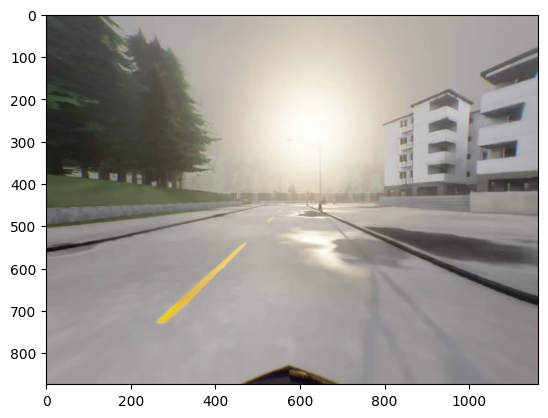

In [105]:
frame = frames[0]
image = Image.fromarray(frame[:, :, ::-1], mode="RGB")
plt.imshow(image)
image.size